To Dos:
- Add Loss Function
- Add Optimization
- Define Variables that should be optimized

In [2]:
import scipy.stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncexpon, truncnorm, nbinom
import pandas as pd
import torch

In [3]:
np.random.seed(seed=101)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd /content/drive/MyDrive/CovidPrediction/

/content/drive/.shortcut-targets-by-id/1Pg1jxQD_gHfZKfWc3NcCyo1kUhmNaccP/CovidPrediction


# Initialization

In [6]:
data = pd.read_csv('data/covid19model.csv')
data.head(3)

,date,hospit,serial_interval,delay_distr
0,2020-02-17,0,0.046535,0.013006
1,2020-02-18,0,0.087065,0.030046
2,2020-02-19,0,0.112061,0.044674


In [7]:
num_impute = 6
observed_daily_hospit = data.hospit.to_numpy()
pi = data.delay_distr.to_numpy()
serial_interval = data.serial_interval.to_numpy()
population = 5793636
num_observations = len(observed_daily_hospit)

Initialize latent variables / parameters

In [8]:
tau = np.random.exponential(1 / 0.03)

# b=(upper-lower)/scale, loc=lower, scale=scale
y = truncexpon.rvs(b=(1000 - 0) / tau, loc=0, scale=tau)  # number of initial newly_infected (seed)

# For trunc ((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
phi = truncnorm.rvs((0 - 0) / 5, (np.inf - 0) / 5, loc=0, scale=5)  # dispersion (shape) parameter for observations
R0 = truncnorm.rvs((2 - 3.6) / 0.8, (5 - 3.6) / 0.8, loc=3.6, scale=0.8)  # initial reproduction number
alpha = truncnorm.rvs((0 - 1/100) / 1/100, (5/100 - 1/100) / 1/100, loc=1/100, scale=1/100)  # probability to get hospitalized
sigma = truncnorm.rvs((0 - 0.05) / 0.03, (0.15 - 0.05) / 0.03, loc=0.05, scale=0.03)  # standart deviation of random walk step

Initialize time series variables

In [9]:
newly_infected = np.zeros(num_observations)  # number of newly infected
effectively_infectious = np.zeros(num_observations)  # effective number of infectious individuals
expected_daily_hospit = np.zeros(num_observations)  # expected number of daily hospitalizations
cumulative_infected = np.zeros(num_observations)  # cumulative number of infected
eta_t = np.zeros(num_observations)  # transformed reproduction number
epsilon_t = np.zeros(num_observations)  # random walk
St = np.zeros(num_observations)  # fraction of susceptible population

seed initial infection / impute first `num_impute` days

In [10]:
#newly_infected[0:num_impute] = y
for i in range(num_impute):
  newly_infected[i] = y

cumulative_infected[0] = 0.
cumulative_infected[1:num_impute] = np.cumsum(newly_infected[0:num_impute - 1])
St[0:num_impute] = np.array([np.maximum(population - x, 0)/population for x in cumulative_infected[0:num_impute]])

# Calculation

calculate Rt: the basic reproduction number

In [11]:
beta_0 = np.log(R0)
epsilon_t[0] = np.random.normal(0, sigma)
for t in range(1, num_observations):
    epsilon_t[t] = np.random.normal(epsilon_t[t-1], sigma)
    eta_t[t] = beta_0 + epsilon_t[t]  # + RNN[X_t, t]

Rt = np.exp(eta_t)

calculate infections

In [12]:
for t in range(num_impute, num_observations):
    # Update cumulative newly_infected
    cumulative_infected[t] = cumulative_infected[t - 1] + newly_infected[t - 1]
    # Adjusts for portion of pop that are susceptible
    St[t] = np.maximum(population - cumulative_infected[t], 0) / population
    # effective number of infectous individuals
    effectively_infectious[t] = np.sum([newly_infected[i] * serial_interval[t-i] for i in range(0, t-1)])
    # number of new infections (unobserved)
    newly_infected[t] = St[t] * Rt[t] * effectively_infectious[t]

In [ ]:
newly_infected

array([2.04756081e+01, 2.04756081e+01, 2.04756081e+01, 2.04756081e+01,
       2.04756081e+01, 2.04756081e+01, 3.00343227e+01, 3.25661671e+01,
       3.91120027e+01, 4.27561497e+01, 4.63418994e+01, 5.76116732e+01,
       6.64319770e+01, 8.98127226e+01, 1.27809494e+02, 1.61698633e+02,
       2.08347866e+02, 3.02703192e+02, 3.37561063e+02, 4.08646859e+02,
       5.13514252e+02, 6.62595575e+02, 8.38424365e+02, 1.07020974e+03,
       1.43872326e+03, 1.83038472e+03, 2.47812497e+03, 3.26880356e+03,
       4.09640238e+03, 5.05235086e+03, 6.06528535e+03, 8.04556526e+03,
       9.98572449e+03, 1.47383025e+04, 1.89194164e+04, 2.91640209e+04,
       3.52016424e+04, 4.90607685e+04, 5.91206643e+04, 7.88051002e+04,
       1.10048083e+05, 1.39389880e+05, 1.80494945e+05, 2.41409567e+05,
       3.57306675e+05, 4.14295797e+05, 4.81993478e+05, 5.38118331e+05,
       5.82186482e+05, 5.50057898e+05, 5.24063249e+05, 4.59072523e+05,
       3.03297321e+05, 2.40092519e+05, 1.25519180e+05, 7.84859453e+04,
      

calculate expected number of hospitalizations

In [13]:
expected_daily_hospit[0] = (1e-15) * newly_infected[0]
for t in range(1, num_observations):
    expected_daily_hospit[t] = alpha * np.sum([newly_infected[i] * pi[t - i] for i in range(0, t - 1)])

# Optimization

In [ ]:
"""expected_daily_hospit_nb = np.zeros(num_observations)
for t in range(2, num_observations):
    expected_daily_hospit_nb[t] = nbinom.rvs(expected_daily_hospit[t], get_phi())"""

'expected_daily_hospit_nb = np.zeros(num_observations)\nfor t in range(2, num_observations):\n    expected_daily_hospit_nb[t] = nbinom.rvs(expected_daily_hospit[t], get_phi())'

# Approch de Haoman

In [14]:
import math
from torch import nn

In [16]:
"""expected_daily_hospit_nb = np.zeros(num_observations)
for t in range(2, num_observations):
    expected_daily_hospit_nb[t] = nbinom.rvs(expected_daily_hospit[t], get_phi())"""



for t in range(1, num_observations):
    # Forward pass: compute predicted y
    expected_daily_hospit[t] = alpha * np.sum([newly_infected[i] * pi[t - i] for i in range(0, t - 1)])
  
difference[t] = expected_daily_hospit[t] - observed_daily_hospit[t]

#is it possible that Andreas wants us to have a logistic ditribution of the difference? 
#then we will have to convert the difference into a vector of size t and output value of size 1, so the sum will be minimized.   
model = nn.Sequential(difference[t],nn.LogSoftmax(dim=1))
    # Define the loss
criterion = nn.NLLLoss()
    # Optimizers require the parameters to optimize and a learning rate
optimizer = optim.SGD(model.parameters(), lr=0.01)

epochs = 10
for e in range(epochs):
    running_loss = 0
    optimizer.zero_grad() # empty the gradients, otherwise gradients are accumulated.
    output = differencesum
    loss = criterion(output, labels)
    loss.backward() # auto-grad 
    optimizer.step() # update  weights 
    running_loss += loss.item()
else:
    print(f"Training epoch {e} : loss: {running_loss/len(trainloader)}")




ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-d7b4dc7f0277>", line 11, in <module>
    difference[t] = expected_daily_hospit[t] - observed_daily_hospit[t]
NameError: name 'difference' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/IPython/core/ultratb.py", line 1132, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_context, tb_offset)
  File "/usr/local/li

NameError: ignored

compare observed hospitalizations to model results

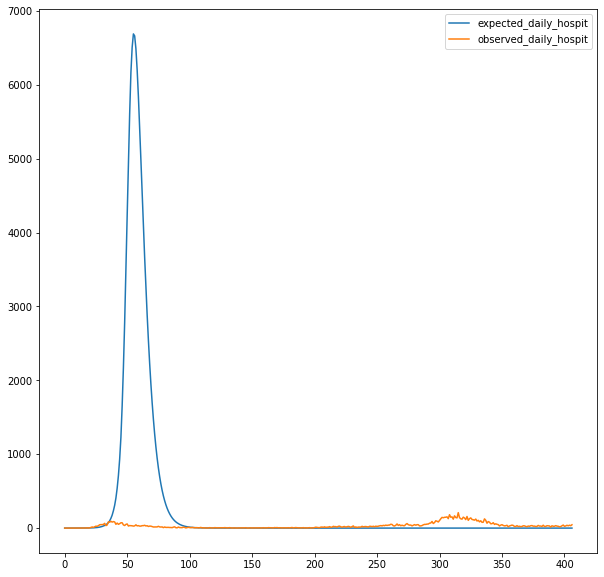

In [32]:
plt.figure(figsize=(10,10))
plt.plot(expected_daily_hospit, label='expected_daily_hospit')
plt.plot(observed_daily_hospit, label='observed_daily_hospit')
plt.legend()
plt.show()